In [1]:
%autoreload 2
import pylab as pl

import jax.numpy as np
from numpy.random import randn
import pytest
from numpy.testing import assert_allclose
from jax import random
from tqdm import tqdm

from jaxrk.rkhs import CovOp, Cdo, Cmo, FiniteMap, FiniteVec, inner, SpVec, CombVec, RolloutSp, RolloutIdx, CovOp, CrossCovOp, CombVec
from jaxrk.kern import (GaussianKernel, LaplaceKernel, SplitDimsKernel, PeriodicKernel, LinearKernel, SpikeKernel)
from jaxrk.utilities.array_manipulation import all_combinations
from jaxrk.reduce import SparseReduce, LinearReduce, BlockReduce
from jaxrk.kern import median_heuristic
from sklearn.datasets import make_moons
from copy import copy
from data import Traffic


traf = Traffic()

idx_out = 40
n = 20
use_inner = "gen_gauss"

traf.data['train'] = Traffic.equalize_smp_size(traf.data['train']).values.reshape(-1, 144, traf.data['test'].shape[-1])
traf.data['test'] = traf.data['test'].values.reshape(-1, 144, traf.data['test'].shape[-1])

In [2]:
max_dim = 2
def add_dimension_index (d):
    idx, dat = np.repeat(d[:, :, :2], d.shape[-1] - 2, axis = 1), d[:, :, 2:].reshape((d.shape[0], -1))
    dim_idx = np.repeat(np.tile(np.arange(d.shape[-1] - 2), d.shape[1]).reshape((1, -1, 1)), d.shape[0], axis=0)
    tme_dim_idx = np.concatenate((idx, dim_idx), -1)
    return tme_dim_idx, dat


train_idx, train_d = add_dimension_index(traf.data['train'][:10,:, :(2+max_dim)])

train_inp = np.vstack(np.concatenate((train_idx[:, :-1, 1:], train_d[:,:-1, np.newaxis]), -1))
train_inp_idx = np.vstack(train_idx[:, 1:, 1:])
train_out = train_d[:, 1:].flatten()[:, np.newaxis]

num_points_per_obs = train_d.shape[1] - 1

In [3]:
train_idx.shape, train_d.shape, train_inp.shape, train_inp_idx.shape

((10, 288, 3), (10, 288), (2870, 3), (2870, 2))

In [4]:
use_combined = True
#(train_inp, train_inp_idx, train_out) = (traf.data['train'][:idx_out, :-1, 1:3].reshape((-1, 2)),
#                                         traf.data['train'][:idx_out, 1:, 1:2].reshape((-1, 1)),
#                                         traf.data['train'][:idx_out, 1:, 2:3].reshape((-1, 1)))
un, cts, sr = SparseReduce.sum_from_unique(train_out.flatten(), mean=True)

In [5]:
obs_median = 0.84 #0.9 #median_heuristic(traf.data['train'][:14, :-1, 2].reshape((-1, 1)), "sqeuclidean")
idx_median = 80 #1e+5 #median_heuristic(traf.data['train'][:14, :-1, 1:2].reshape((-1, 1)), "sqeuclidean")
print(obs_median, idx_median)

out_kern = LaplaceKernel(obs_median)
period = train_inp_idx.max(0)
idx_kern = SplitDimsKernel([0, 1, 2], [PeriodicKernel(period[0], 1), SpikeKernel(1, 0.7)])
gauss_idx_kern = LaplaceKernel(idx_median)
#idx_kern = GaussianKernel(idx_median)
in_kern = SplitDimsKernel([0, 1, 2], [idx_kern, out_kern])

downweight_second_add = lambda x,y: x+y

#

out_vec_gr = FiniteVec(out_kern, un[:, np.newaxis],)

#

out_vec = FiniteVec(out_kern, train_out)

if not use_combined:
    inp_vec = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner)
    inp_vec_gr = SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner, reduce = [sr])
else:
    inp_vec = CombVec(SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner), FiniteVec(gauss_idx_kern, train_inp_idx), downweight_second_add)
    inp_vec_gr = CombVec(SpVec(in_kern, train_inp, np.arange(1, train_inp.shape[0] // num_points_per_obs + 1) * num_points_per_obs, use_inner=use_inner), FiniteVec(gauss_idx_kern, train_inp_idx), downweight_second_add, reduce = [sr])
print(len(inp_vec), len(inp_vec_gr))
ir = RolloutIdx(train_inp_idx, example = train_inp_idx)

0.84 80
2870 10


In [6]:
e = 0.24*2 #e = 2*b
ei = 1./e
c = 0.9

In [7]:
O = Cmo(inp_vec, out_vec, 1./cts.sum()**(e*c), center = True)
test_inp = traf.data['test'][:1, :n, 1:3].reshape((-1, 2))
#test_inp[:, 1:] = stats.norm.ppf(to.cdf(test_inp[:, 1:]))
test_out = traf.data['test'][:1, n:, 2:3]
#test_out = stats.norm.ppf(to.cdf(traf.data['train'][idx_out, n:, 2:3]))


#test_inp_idx = np.vstack(test_idx[:, 1:, 1:])
#test_out = test_d[:, 1:].flatten()[:, np.newaxis]



In [8]:
test_idx, test_d = add_dimension_index(traf.data['test'][:1,:, :(2+max_dim)])

test_inp_full = np.vstack(np.concatenate((test_idx[:, :-1, 1:], test_d[:,:-1, np.newaxis]), -1))
test_inp = test_inp_full[:n*max_dim]
inp_test = SpVec(in_kern, test_inp, np.array([test_inp.shape[0]]), use_subtrajectories = False, use_inner=use_inner)

ir.current = test_inp[-1, :-1]
len(test_inp)

40

In [9]:
cur_ro = RolloutSp(O, inp_test, max_dim + 1, ir)
rval = []
rval_idx = []
for i, idx in tqdm(enumerate(ir)):
    new_point = cur_ro.get_embedding().point_representant()
    rval.append(new_point)
    rval_idx.append(idx)
    cur_ro.update(new_point, idx)
    if i > 122*max_dim:
        break
rval_idx = np.array(rval_idx)
rval = np.array(rval)[:-2].reshape((-1, max_dim))

0it [00:01, ?it/s]


TypeError: object of type 'bool' has no len()

In [10]:
%debug

> /Users/ischuster/Documents/university/Promotion_NLP/software/JaxRk/jaxrk/rkhs/vector.py(250)gram_projection()
    248 def gram_projection(G_repr_orig:np.array, G_repr:np.array=None, G_orig:np.array=None, method:str = "representer"):
    249 
--> 250     assert len(G_repr.shape) == 2 and len(G_orig.shape) == 2 and len(G_repr_orig.shape==2)
    251     assert G_repr.shape[0] == G_repr.shape[1] and G_orig.shape[0] == G_orig.shape[1]
    252     assert G_repr_orig.shape[0] == G_repr.shape[0] and G_repr_orig.shape[1] == G_orig.shape[1]

> /Users/ischuster/Documents/university/Promotion_NLP/software/JaxRk/jaxrk/rkhs/vector.py(174)point_representant()
    172                 self._raw_gram_cache = n.k(n.inspace_points).astype(np.float64)
    173             G_repr_orig = Reduce.apply(self._raw_gram_cache, self.reduce, 1)
--> 174             repr_idx = gram_projection(G_repr_orig, self._raw_gram_cache, Reduce.apply(G_repr_orig, self.reduce, 0))
    175             assert False
    176       

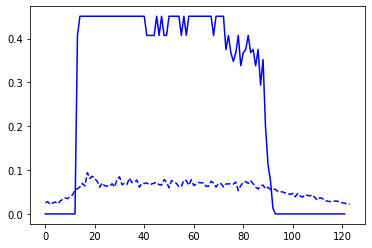

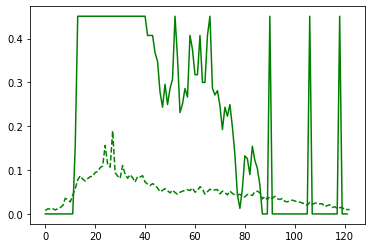

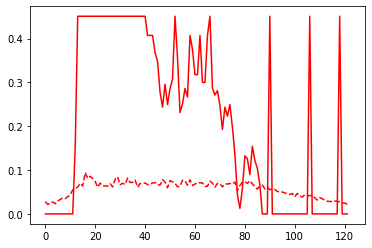

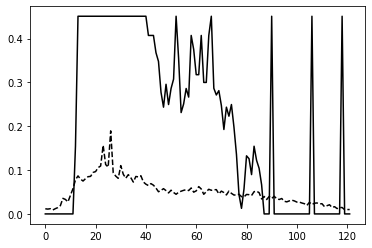

<Figure size 432x288 with 0 Axes>

In [18]:
#index and history input
start = n*max_dim
for dim, color in [(0, "b"), (1, "g"), (2, "r"), (3, "k")
                   ]:
    pl.plot(rval.T[dim], color)
    pl.plot(test_inp_full.T[-1, start+dim:len(test_inp_full):max_dim], "--"+color)
    pl.figure()


In [21]:
def redInvBu(G, correct = False):
    G_tilde = A@G@A.T
    rval = A.T@np.linalg.inv(G_tilde+alpha * C_inv)@A
    if not correct:
        return rval
    else:
        true_diag = (1./(np.diag(G) + alpha))
        sqr_frac = np.sqrt(true_diag/np.diag(rval))
        f = np.outer(sqr_frac, sqr_frac)
        return rval * f

In [11]:
#O_gr = Cmo(inp_vec_gr, out_vec_gr, 0.1/cts**0.1)
#O_gr = Cmo(inp_vec_gr, out_vec_gr, (cts/ cts.sum())**0.009)
C = np.diag(cts.squeeze())
cts_inv = np.diag(1./cts.squeeze())
alpha = 1./(cts.sum()**(e*c))
aI = alpha * np.eye(cts.size)
cn = C #C#/np.diag(C).sum()*20



O_gr = {
        #"redInvBuCorr":Cmo(inp_vec, out_vec, regul_func=lambda G: redInvBu(G, True)),
       # "redInvBu":Cmo(inp_vec, out_vec, regul_func=redInvBu ),
       # "rvecInv":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: C@np.linalg.inv(C@G_tilde@C+alpha * C)@C),

       "rveNormal":Cmo(inp_vec_gr, out_vec_gr, aI),
       "rvecInv2":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: np.linalg.inv(G_tilde+alpha * C)),

       # "rvecInvAvg":Cmo(inp_vec_gr, out_vec_gr, regul_func=lambda G_tilde: (np.linalg.inv(G_tilde+alpha * C_inv) + C@np.linalg.inv(cn@G_tilde@cn+alpha * cn)@C)/2),
        }
#O_gr = Cmo(inp_vec_gr, out_vec_gr, 1./(cts * (cts.sum()**0.049))) #:

In [14]:
C.shape, aI.shape

((1204, 1204), (1204, 1204))

In [12]:
test_idx, test_d = add_dimension_index(traf.data['test'][:1,:, :(2+max_dim)])

test_inp_full = np.vstack(np.concatenate((test_idx[:, :-1, 1:], test_d[:,:-1, np.newaxis]), -1))
test_inp = test_inp_full[:n*max_dim]
inp_test = SpVec(in_kern, test_inp, np.array([test_inp.shape[0]]), use_subtrajectories = False, use_inner=use_inner)

ir.current = test_inp[-1, :-1]


rval_gr = {}
rval_idx_gr = {}
for k in O_gr:
    cur_ro_gr = RolloutSp(O_gr[k], inp_test, max_dim + 1, ir)
    ir.current = test_inp[-1, :-1]
    rval_gr[k] = []
    rval_idx_gr[k] = []
    for i, idx in tqdm(enumerate(ir)):
        new_point = cur_ro_gr.get_embedding().point_representant()
        rval_gr[k].append(new_point)
        rval_idx_gr[k].append(idx)
        cur_ro_gr.update(new_point, idx)
        if i > 122*max_dim:
            break
    rval_idx_gr[k] = np.array(rval_idx_gr[k])
    rval_gr[k] = np.array(rval_gr[k])[:-2].reshape((-1, max_dim))


0it [00:00, ?it/s]
1it [00:00,  3.57it/s]
2it [00:00,  3.17it/s]
3it [00:01,  2.94it/s]
4it [00:01,  2.73it/s]
5it [00:01,  2.71it/s]
6it [00:02,  2.64it/s]
7it [00:02,  2.61it/s]
8it [00:03,  2.58it/s]
9it [00:03,  2.62it/s]
10it [00:03,  2.61it/s]
11it [00:04,  2.29it/s]
12it [00:04,  2.32it/s]
13it [00:05,  2.28it/s]
14it [00:05,  2.25it/s]
15it [00:06,  2.16it/s]
16it [00:07,  1.70it/s]
17it [00:08,  1.33it/s]
18it [00:10,  1.11s/it]
19it [00:11,  1.07s/it]
20it [00:11,  1.12it/s]
21it [00:12,  1.02it/s]
22it [00:13,  1.13it/s]
23it [00:14,  1.26it/s]
24it [00:14,  1.37it/s]
25it [00:16,  1.11s/it]
26it [00:19,  1.62s/it]
27it [00:20,  1.50s/it]
28it [00:21,  1.31s/it]
29it [00:22,  1.21s/it]
30it [00:23,  1.07s/it]
31it [00:24,  1.01s/it]
32it [00:24,  1.11it/s]
33it [00:25,  1.21it/s]
34it [00:26,  1.29it/s]
35it [00:26,  1.34it/s]
36it [00:27,  1.44it/s]
37it [00:28,  1.30it/s]
38it [00:28,  1.37it/s]
39it [00:29,  1.42it/s]
40it [00:30,  1.46it/s]
41it [00:30,  1.53it/s]
42it 

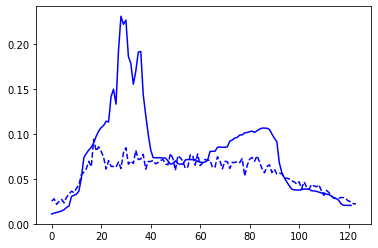

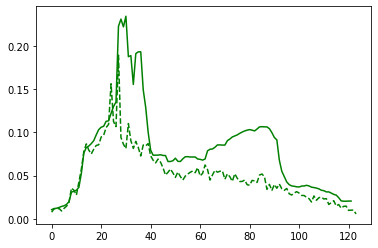

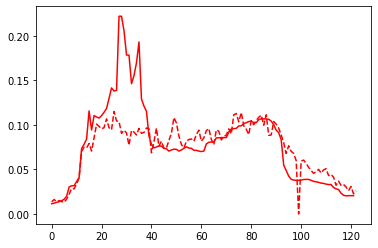

<Figure size 432x288 with 0 Axes>

In [13]:
#no index input, just history
start = n*max_dim
for dim, color in [(0, "b"), (1, "g"), (2, "r")
                   ]:
    pl.plot(rval_gr["rvecInv2"].T[dim], color)
    pl.plot(test_inp_full.T[-1, start+dim:len(test_inp_full):max_dim], "--"+color)
    pl.figure()
